In [62]:
import numpy as np
import csv

with open('fmnist_train.csv','r') as f:
    reader = csv.reader(f)
    data = list(reader)

data_array = np.array(data, dtype=int)
ones = np.ones((data_array.shape[0],1))
data_array = np.append(data_array, ones, axis=1)

data_x = data_array[:,1:]
data_y = data_array[:,0]

In [63]:
# Binary case
srn = 22205
c0, c1 = np.random.default_rng(srn).choice(range(0,10),size=2,replace=False)
binary_x = data_x[(data_y == c0) | (data_y == c1)]
binary_y = data_y[(data_y == c0) | (data_y == c1)]

for i in range(len(binary_y)):
    if binary_y[i] == c0:
        binary_y[i] = -1
    else:
        binary_y[i] = 1

In [64]:
from cvxopt import matrix, solvers
from scipy.linalg import block_diag

P1 = np.identity(binary_x.shape[1]-1)
P2 = np.zeros((binary_x.shape[0]+1, binary_x.shape[0]+1))
P = matrix(block_diag(P1, P2))

C = 100
q1 = np.zeros(binary_x.shape[1])
q2 = C*np.ones(binary_x.shape[0])
q = matrix(np.concatenate((q1, q2)))

topleft = np.zeros((binary_x.shape[0], binary_x.shape[1]))
for i in range(binary_x.shape[0]):
    for j in range(binary_x.shape[1]):
        topleft[i][j] = (-1)*binary_y[i]*binary_x[i][j]

topright = (-1)*np.identity(binary_x.shape[0])
bottomleft = np.zeros((binary_x.shape[0], binary_x.shape[1]))
bottomright = (-1)*np.identity(binary_x.shape[0])

G = matrix(np.block([[topleft, topright], [bottomleft, bottomright]]))

h1 = (-1)*np.ones(binary_x.shape[0])
h2 = np.zeros(binary_x.shape[0])
h = matrix(np.concatenate((h1, h2)).reshape(-1,1))

sol = solvers.qp(P, q, G, h)
w = sol['x'][:binary_x.shape[1]]

print(w)

     pcost       dcost       gap    pres   dres
 0: -9.8548e+06  2.7395e+06  7e+06  2e+02  8e+03
 1: -6.8776e+05 -2.9825e+05  8e+05  2e+01  7e+02
 2: -3.2567e+04 -1.7417e+04  4e+04  8e-01  4e+01
 3: -2.8932e+03 -1.6914e+03  4e+03  8e-02  3e+00
 4: -2.9351e+02 -1.8944e+02  5e+02  9e-03  4e-01
 5: -3.2293e+01 -2.4948e+01  7e+01  1e-03  5e-02
 6: -4.2804e+00 -4.4004e+00  1e+01  2e-04  8e-03
 7: -4.8636e-01 -7.7605e-01  2e+00  3e-05  1e-03
 8:  6.1442e-02 -4.7129e-02  1e-01  4e-08  2e-06
 9:  7.8741e-03 -6.3870e-03  1e-02  9e-14  5e-16
10:  1.2675e-03 -7.8823e-04  2e-03  3e-14  5e-16
11:  2.3895e-04 -4.7456e-05  3e-04  1e-14  6e-16
12:  1.1056e-04  2.7494e-05  8e-05  5e-15  5e-16
13:  8.7455e-05  4.8764e-05  4e-05  3e-15  8e-16
14:  7.6728e-05  5.9832e-05  2e-05  2e-15  2e-16
15:  6.8188e-05  6.3707e-05  4e-06  2e-15  5e-16
16:  6.5677e-05  6.5182e-05  5e-07  2e-15  5e-16
17:  6.5394e-05  6.5371e-05  2e-08  2e-15  6e-16
Optimal solution found.
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[-6.78e-11

In [65]:
with open('fmnist_test.csv','r') as f:
    reader = csv.reader(f)
    test_data = list(reader)

test_data_array = np.array(test_data, dtype=int)
ones = np.ones((test_data_array.shape[0],1))
test_data_array = np.append(test_data_array, ones, axis=1)

test_data_x = test_data_array[:,1:]
test_data_y = test_data_array[:,0]

srn = 22205
c0, c1 = np.random.default_rng(srn).choice(range(0,10),size=2,replace=False)
test_binary_x = test_data_x[(test_data_y == c0) | (test_data_y == c1)]
test_binary_y = test_data_y[(test_data_y == c0) | (test_data_y == c1)]

for i in range(len(test_binary_y)):
    if test_binary_y[i] == c0:
        test_binary_y[i] = -1
    else:
        test_binary_y[i] = 1

correct = 0
for i in range(test_binary_x.shape[0]):
    if np.dot(test_binary_x[i], w) >= 0:
        if test_binary_y[i] == 1:
            correct += 1
    else:
        if test_binary_y[i] == -1:
            correct += 1

print(correct/test_binary_x.shape[0])

0.975


In [101]:
# Dual
P_dual = matrix(np.matmul(topleft,topleft.T))

q_dual = (-1)*matrix(np.ones(binary_x.shape[0]).reshape(-1,1))

G1_dual = (-1)*np.identity(binary_x.shape[0])
G2_dual = np.identity(binary_x.shape[0])
G_dual = matrix(np.concatenate((G1_dual, G2_dual)))

C_dual = 100
h1_dual = np.zeros(binary_x.shape[0])
h2_dual = C_dual*np.ones(binary_x.shape[0])
h_dual = matrix(np.concatenate((h1_dual, h2_dual)).reshape(-1,1))

A_dual = matrix(binary_y.reshape(1,-1))
b_dual = matrix(np.zeros(1))

sol_dual = solvers.qp(P_dual, q_dual, G_dual, h_dual, A_dual, b_dual)
lambda_dual = sol_dual['x']

print(lambda_dual)

w_dual = np.zeros(binary_x.shape[1])
for i in range(binary_x.shape[0]):
    w_dual += lambda_dual[i]*binary_y[i]*binary_x[i]


     pcost       dcost       gap    pres   dres
 0:  4.4103e+02 -2.8851e+06  7e+06  4e-01  9e-07
 1:  7.2635e+02 -4.9162e+05  8e+05  4e-02  8e-07
 2:  9.3217e+01 -2.6508e+04  4e+04  2e-03  1e-07
 3:  1.5004e+01 -2.7067e+03  4e+03  2e-04  1e-08
 4:  3.9289e+00 -3.1825e+02  5e+02  2e-05  1e-09
 5:  1.0469e+00 -4.4874e+01  7e+01  2e-06  2e-10
 6:  3.4588e-01 -8.4923e+00  1e+01  4e-07  3e-11
 7:  1.3832e-01 -1.5955e+00  2e+00  6e-08  6e-12
 8:  4.6480e-02 -6.4186e-02  1e-01  8e-11  1e-12
 9:  6.3870e-03 -7.8741e-03  1e-02  2e-16  5e-13
10:  7.8823e-04 -1.2675e-03  2e-03  2e-16  2e-13
11:  4.7456e-05 -2.3895e-04  3e-04  2e-16  7e-14
12: -2.7494e-05 -1.1056e-04  8e-05  2e-16  3e-14
13: -4.8764e-05 -8.7455e-05  4e-05  2e-16  3e-14
14: -5.9832e-05 -7.6728e-05  2e-05  2e-16  3e-14
15: -6.3707e-05 -6.8188e-05  4e-06  2e-16  4e-14
16: -6.5182e-05 -6.5677e-05  5e-07  2e-16  4e-14
17: -6.5371e-05 -6.5394e-05  2e-08  2e-16  4e-14
Optimal solution found.
[ 1.60e-10]
[ 4.92e-10]
[ 4.71e-12]
[ 4.85e-12

In [67]:
correct = 0
for i in range(test_binary_x.shape[0]):
    if np.dot(test_binary_x[i], w_dual) >= 0:
        if test_binary_y[i] == 1:
            correct += 1
    else:
        if test_binary_y[i] == -1:
            correct += 1

print(correct/test_binary_x.shape[0])

0.65


In [68]:
#Kernel
def kernel(x1, x2, sigma):
    r = np.exp((-0.5)*(np.linalg.norm(np.subtract(x1,x2)))**2/(sigma**2))
    if r < 1e-9:
        r = 1e-9
    return r

sigma = 1
topleft_kernel = np.zeros((binary_x.shape[0], binary_x.shape[0]))
for i in range(binary_x.shape[0]):
    for j in range(binary_x.shape[0]):
        topleft_kernel[i][j] = binary_y[i]*binary_y[j]*kernel(binary_x[i], binary_x[j], sigma)

P_kernel = matrix(topleft_kernel)
sol_kernel = solvers.qp(P_kernel, q_dual, G_dual, h_dual, A_dual, b_dual)
lambda_kernel = sol_kernel['x']
print(lambda_kernel)


     pcost       dcost       gap    pres   dres
 0:  5.3306e+05 -6.6672e+05  1e+06  6e-13  7e-14
 1:  7.5162e+04 -1.2305e+05  2e+05  1e-12  2e-14
 2:  9.3006e+03 -1.5886e+04  3e+04  5e-13  6e-15
 3:  4.8905e+02 -3.0944e+03  4e+03  4e-13  2e-15
 4: -4.4954e+02 -8.8856e+02  4e+02  1e-13  1e-15
 5: -4.9976e+02 -5.2312e+02  2e+01  4e-15  5e-16
 6: -5.0000e+02 -5.0025e+02  2e-01  1e-14  2e-16
 7: -5.0000e+02 -5.0000e+02  2e-03  3e-14  2e-16
 8: -5.0000e+02 -5.0000e+02  2e-05  4e-16  2e-16
Optimal solution found.
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e

In [69]:
correct = 0
sum = 0

for i in range(test_binary_x.shape[0]):
    sum = 0
    for j in range(binary_x.shape[0]):
        sum += lambda_kernel[j]*binary_y[j]*kernel(test_binary_x[i], binary_x[j], sigma)

    if  sum >= 0:
        if test_binary_y[i] == 1:
            correct += 1
    else:
        if test_binary_y[i] == -1:
            correct += 1

print(correct/test_binary_x.shape[0])

0.5


In [99]:
from sklearn import svm
C = 1

scikit = svm.SVC(C=C, kernel='linear').fit(test_binary_x, test_binary_y)

correct = 0
for i in range(test_binary_x.shape[0]):
    if test_binary_y[i]*scikit.decision_function([test_binary_x[i]]):
        correct += 1

print(correct/test_binary_x.shape[0])


1.0


In [70]:
#q2
house_data = np.genfromtxt('house_price_prediction.csv', delimiter=',', skip_header=1, usecols=range(2,21))

house_train_y = house_data[:int(0.8*house_data.shape[0]), 0]
house_test_y = house_data[int(0.8*house_data.shape[0]):, 0]

house_data = house_data[:,1:]
ones = np.ones((house_data.shape[0],1))
house_data = np.append(ones, house_data, axis=1)

house_train_x = house_data[:int(0.8*house_data.shape[0])]
house_test_x = house_data[int(0.8*house_data.shape[0]):]


In [71]:
w_house_linear = np.matmul(np.matmul(np.linalg.inv(np.matmul(house_train_x.T, house_train_x)), house_train_x.T), house_train_y.T)
print(w_house_linear)

lambda_ridge = 1
w_house_ridge = np.matmul(np.matmul(np.linalg.inv(np.matmul(house_train_x.T, house_train_x) + lambda_ridge*np.identity(house_train_x.shape[1])), house_train_x.T), house_train_y.T)
print(w_house_ridge)

[ 5.49362141e+06 -1.78204371e+05  2.79950417e+05 -2.65743107e+04
  2.74676222e+00  1.35401589e+06 -1.98064512e+05  4.86233602e+03
  6.62587917e+04  2.43501762e+05  2.64773333e+04  2.67267336e+04
 -2.78630247e+03  1.20477508e+01 -4.00899067e+02  4.75922794e+05
 -1.07248073e+05  9.22930896e+01  2.80916391e-01]
[ 1.23409589e+03 -2.01301366e+04  1.93398734e+04  7.84648857e+01
 -1.73314959e-01  5.86940922e+04  4.04712889e+05  4.55137502e+04
  3.50305147e+04  8.36849481e+04  1.92596693e+01  5.91930497e+01
 -2.74436198e+03  1.30133429e+01 -2.89528106e+02  4.39074160e+05
 -9.98845514e+04  9.50398508e+01  2.13554521e-01]


In [72]:
linear_mse = 0
ridge_mse = 0

linear_predictions = np.matmul(house_test_x, w_house_linear)
ridge_predictions = np.matmul(house_test_x, w_house_ridge)

for i in range(house_test_x.shape[0]):
    linear_mse += (house_test_y[i] - linear_predictions[i])**2
    ridge_mse += (house_test_y[i] - ridge_predictions[i])**2

print(linear_mse/house_test_x.shape[0])
print(ridge_mse/house_test_x.shape[0])

706043694749.2191
26275436567.922897


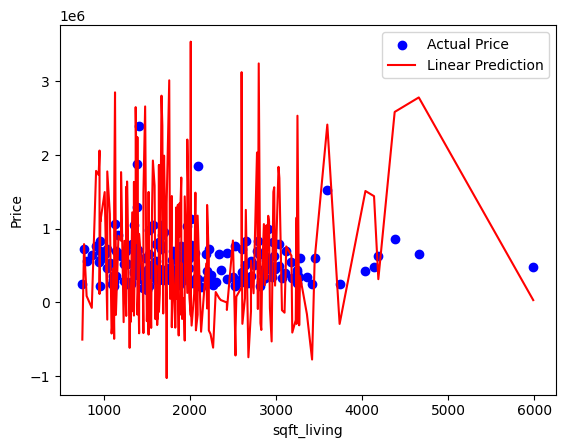

In [92]:
import matplotlib.pyplot as plt

#plot scatter plot for predicted price vs sqft_living
sqft_living = np.sort(house_test_x[:,3])

plt.scatter(sqft_living, house_test_y, color='blue', label='Actual Price')
plt.plot(sqft_living, linear_predictions, color='red', label='Linear Prediction')
plt.xlabel('sqft_living')
plt.ylabel('Price')
plt.legend()
plt.show() 


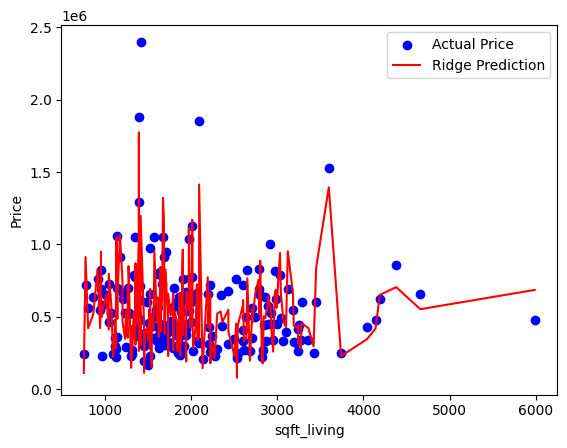

In [93]:
plt.scatter(sqft_living, house_test_y, color='blue', label='Actual Price')
plt.plot(sqft_living, ridge_predictions, color='red', label='Ridge Prediction')
plt.xlabel('sqft_living')
plt.ylabel('Price')
plt.legend()
plt.show() 

c:\Users\adity\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


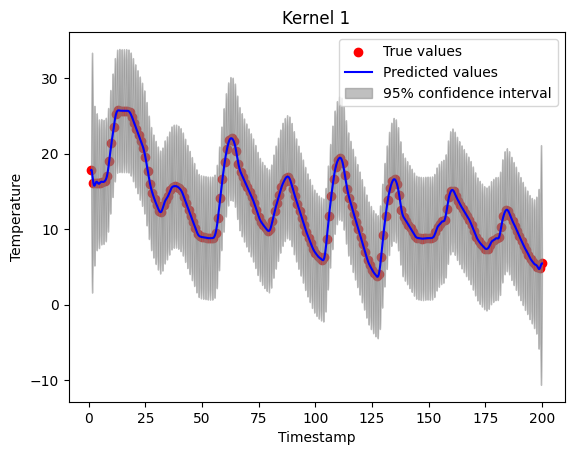

In [74]:
weather_data = np.genfromtxt('weather_data.csv', delimiter=',', skip_header=1)
temps = np.genfromtxt('weather_data.csv', delimiter=',', skip_header=1, usecols=0)

X = np.atleast_2d([float(i) for i in range(1,201)]).T
y = np.atleast_2d(np.linspace(1,200,10000)).T

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as CK
from sklearn.gaussian_process.kernels import ExpSineSquared as ESS
from sklearn.gaussian_process.kernels import RationalQuadratic as RQ

kernel1 = CK()*ESS(length_scale=24, periodicity=1)
kernel2 = CK()*RQ(length_scale=24, alpha=1)
kernel3 = CK()*(ESS(length_scale=24, periodicity=1) + RQ(length_scale=24, alpha=0.5))
kernel4 = CK()*ESS(length_scale=24, periodicity=1)*RQ(length_scale=24, alpha=0.5)

gpr1 = GaussianProcessRegressor(kernel=kernel1, n_restarts_optimizer=20).fit(X, weather_data)

mean1, std1 = gpr1.predict(y, return_std=True)

plt.title('Kernel 1')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.scatter(np.linspace(1,200,200), temps, color='red', label='True values')
plt.plot(y, mean1[:,0], color='blue', label='Predicted values')
plt.fill_between(y[:,0], mean1[:,0] - 1.96*std1[:,0], mean1[:,0] + 1.96*std1[:,0], color='grey', alpha=0.5, label='95% confidence interval')
plt.legend()
plt.show()


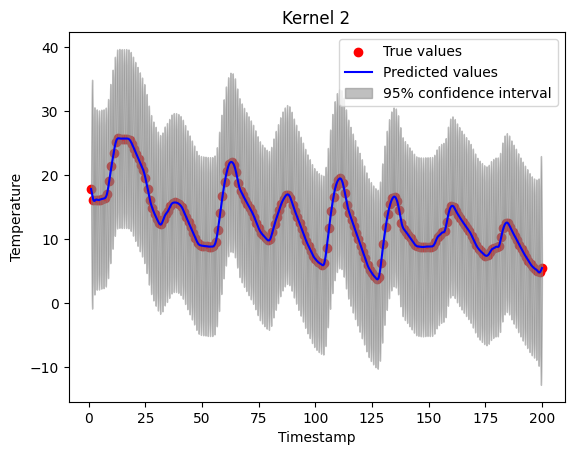

In [75]:
gpr2 = GaussianProcessRegressor(kernel=kernel2, n_restarts_optimizer=20).fit(X, weather_data)

mean2, std2 = gpr2.predict(y, return_std=True)

plt.title('Kernel 2')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.scatter(np.linspace(1,200,200), temps, color='red', label='True values')
plt.plot(y, mean2[:,0], color='blue', label='Predicted values')
plt.fill_between(y[:,0], mean2[:,0] - 1.96*std2[:,0], mean2[:,0] + 1.96*std2[:,0], color='grey', alpha=0.5, label='95% confidence interval')
plt.legend()
plt.show()


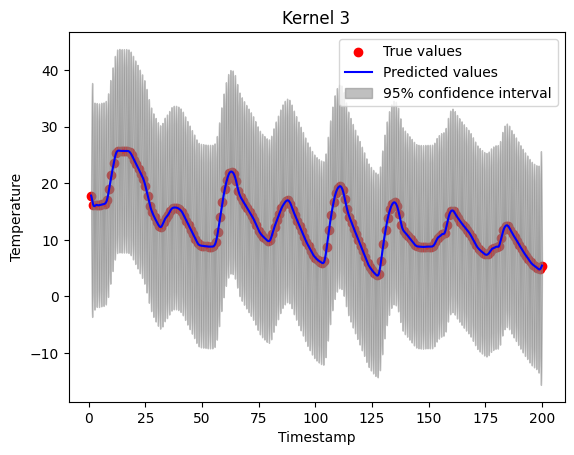

In [79]:
gpr3 = GaussianProcessRegressor(kernel=kernel3, n_restarts_optimizer=20).fit(X, weather_data)

mean3, std3 = gpr3.predict(y, return_std=True)

plt.title('Kernel 3')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.scatter(np.linspace(1,200,200), temps, color='red', label='True values')
plt.plot(y, mean3[:,0], color='blue', label='Predicted values')
plt.fill_between(y[:,0], mean3[:,0] - 1.96*std3[:,0], mean3[:,0] + 1.96*std3[:,0], color='grey', alpha=0.5, label='95% confidence interval')
plt.legend()
plt.show()


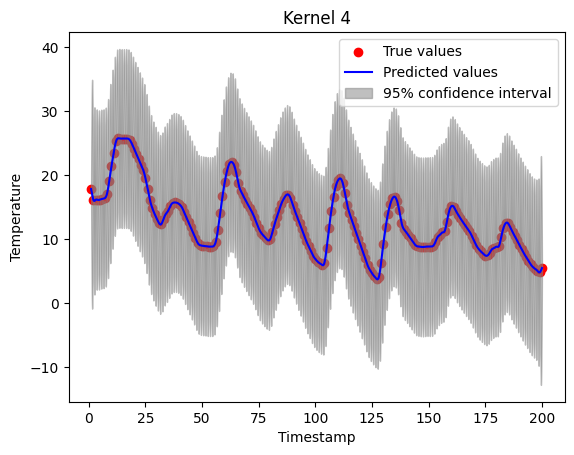

In [83]:
gpr4 = GaussianProcessRegressor(kernel=kernel4, n_restarts_optimizer=20).fit(X, weather_data)

mean4, std4 = gpr4.predict(y, return_std=True)

plt.title('Kernel 4')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.scatter(np.linspace(1,200,200), temps, color='red', label='True values')
plt.plot(y, mean4[:,0], color='blue', label='Predicted values')
plt.fill_between(y[:,0], mean4[:,0] - 1.96*std4[:,0], mean4[:,0] + 1.96*std4[:,0], color='grey', alpha=0.5, label='95% confidence interval')
plt.legend()
plt.show()
